In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/pancreas`


In [21]:
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using Distances
using CUDA
using CSV
using DataFrames
using EvalMetrics
PLT_CELL = 500
FIG_DIR = "./"
DATA_DIR = "../../data/pancreas/"

"../../data/pancreas/"

In [22]:
X = npzread(string(DATA_DIR, "X.npy"))
X_pca = npzread(string(DATA_DIR, "X_pca.npy"))
X_umap = npzread(string(DATA_DIR, "X_umap.npy"))
P = npzread(string(DATA_DIR, "P_statot.npy"));
P = npzread(string(DATA_DIR, "P.npy"));
C = npzread(string(DATA_DIR, "C.npy"));
C /= mean(C);
dpt = npzread(string(DATA_DIR, "dpt.npy"));
J = npzread(string(DATA_DIR, "J.npy"));

try
    global genes = Array(CSV.read(string(DATA_DIR, "genes.txt"), DataFrame))
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)];
end;

In [23]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);

k = 1
π_unif = fill(1/size(P, 1), size(P, 1))'
Q = (P' .* π_unif)./(π_unif * P)';
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse(P^k);

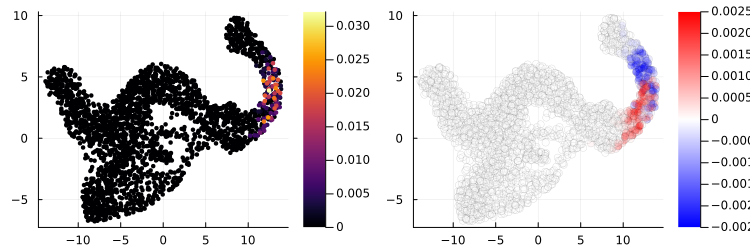

In [24]:
p0 = R[sortperm(dpt)[250], :]
plot(scatter(X_umap[sortperm(p0), 1], X_umap[sortperm(p0), 2]; marker_z = sort(p0), markerstrokewidth = 0, alpha = 1.0, markersize = 2.5), 
    scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = P_sp'*p0 - (QT_sp)*p0, color = :bwr, clim = (-0.0025, 0.0025), markerstrokewidth = 0.5, alpha = 0.25); 
    legend = nothing, colorbar = true, size = (1.5*PLT_CELL, 0.5*PLT_CELL))

In [25]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [26]:
alg = DiscretizeBayesianBlocks()
disc = locaTE.discretizations_bulk(X; alg = alg);

In [27]:
disc_max_size = maximum(map(x -> length(x[1])-1, disc))
N_blocks = 1
joint_cache = get_joint_cache(size(X, 2) ÷ N_blocks, disc_max_size);
ids_cu = hcat(map(x -> x[2], disc) ...) |> cu;

In [28]:
P_cu = cu(Array(P_sp))
QT_cu = cu(Array(QT_sp))
R_cu = cu(Array(R_sp));

In [29]:
mi_all_gpu = zeros(Float32, size(X, 1), size(X, 2), size(X, 2)) |> cu
p = Progress(size(X, 1));
for i in 1:size(X, 1)
    gamma, idx0, idx1 = locaTE.getcoupling_dense_trimmed(i, P_cu, QT_cu, R_cu) 
    for ((N_x, N_y), (offset_x, offset_y)) in locaTE.getblocks(size(X, 2), N_blocks, N_blocks)
        get_MI!(view(mi_all_gpu, i, :, :), joint_cache, gamma, size(X, 2), ids_cu[idx0, :], ids_cu[idx1, :]; offset_x = offset_x, N_x = N_x, offset_y = offset_y, N_y = N_y)
    end
    next!(p)
end
mi_all = reshape(mi_all_gpu, size(X, 1), size(X, 2)^2) |> Array;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


In [30]:
@info "Applying CLR"
mi_all_clr = apply_wclr(mi_all, size(X, 2))
mi_all_clr[isnan.(mi_all_clr)] .= 0
@info "Denoising"
w = vec(sqrt.(sum(mi_all.^2; dims = 2)))
w /= sum(w)
G = fitsp(cu(mi_all_clr), cu(Array(L)); λ1 = 10.0, λ2 = 0.001, maxiter = 250) |> Array;

[ Info: Applying CLR
[ Info: Denoising
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
[ Info: ΔX = 2.0135734088917213e-7, ΔZ = 3.8063225689694e-5, ΔW = 4.024687492031054e-5
[ Info: tr(X'LX) = 1.1666158324341636, 0.5|X-G|^2 = 3.8961037227238235, |X|1 = 9243.235199790339


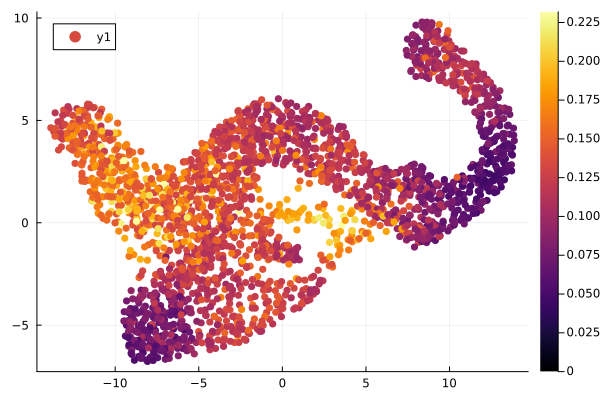

In [31]:
G_rms = vec(sqrt.(sum(G.^2; dims = 2)))
scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = G_rms, markerstrokewidth = 0, clim = (0, quantile(G_rms, 0.995)), alpha = 1)

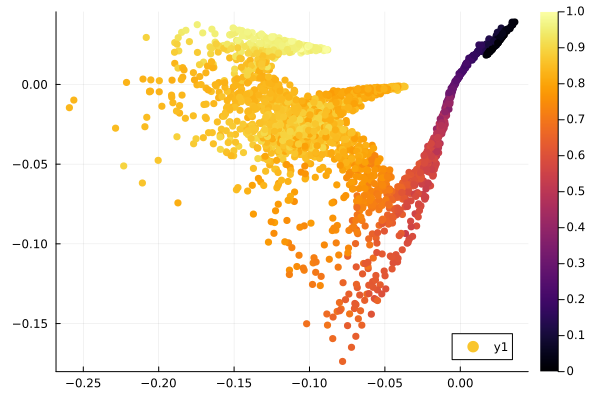

In [32]:
using MultivariateStats
M = fit(PCA, G'; maxoutdim = 3)
G_pca = (M.proj' * G')'
scatter(G_pca[:, 1], G_pca[:, 2]; marker_z = dpt, markerstrokewidth = 0)

In [33]:
# write to csv so we can plot using scVelo
npzwrite(string(DATA_DIR, "G.npy"), G)
CSV.write(string(DATA_DIR, "G_pca.csv"), DataFrame(G_pca, :auto))

"../../data/pancreas/G_pca.csv"

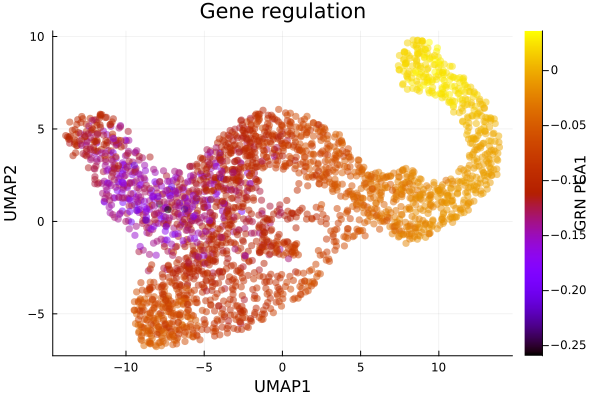

In [34]:
plt=scatter(X_umap[:, 1], X_umap[:, 2]; markerstrokewidth = 0, c = :gnuplot, marker_z = G_pca[:, 1], legend = nothing, alpha = 0.5, 
    xlabel = "UMAP1", ylabel = "UMAP2", title = "Gene regulation", colorbar = true, colorbartitle = "GRN PCA1")
savefig(string(FIG_DIR, "pancreas_umap_grn_pca.pdf"))
plt